Import MNIST Dataset

In [2]:
from __future__ import print_function
import tensorflow as tf
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams['figure.figsize'] = (16.0, 9.0)
import numpy as np
# Seed
np.random.seed(1)

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


**3.1 Same Distribution**

1. Split the MNIST dataset, such that 7 classes are the source domain and the other 3 classes are the target domain.
2. Start with the source domain data set and train a model on it.
3. From the trained model, cut off the final classification layer and replace it with a new layer for the target domain classes. For now, keep all layers trainable.
4. Now train this model on the target domain data set. For comparison, also train a freshly initialized model on the target domain data set.
5. How well did the transfer learning work, compared to training on the target data set from scratch?



In [8]:
num_digits_to_classify = 7

source_train_mask06 = np.isin(y_train,[0,1,2,3,4,5,6])
source_test_mask06 = np.isin(y_test,[0,1,2,3,4,5,6])


x_train06, y_train06 = x_train[source_train_mask06], y_train[source_train_mask06]
x_test06, y_test06 = x_test[source_test_mask06], y_test[source_test_mask06]



#x_train06, y_train06 = x_train[source_train_mask06], y_train[source_train_mask06]
#x_train79, y_train79 = x_train[domain_train_mask79], y_train[domain_train_mask79]


#x_test06, y_test06 = x_train[source_test_mask06], y_train[source_test_mask06]
#x_test79, y_test79 = x_train[domain_test_mask79], y_train[domain_test_mask79]




In [9]:
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train06 = x_train06.reshape(x_train06.shape[0], 28, 28, 1)
x_test06 = x_test06.reshape(x_test06.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train06 = x_train06.astype('float32')
x_test06 = x_test06.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train06 /= 255
x_test06 /= 255





In [10]:
def create_model():
    model = Sequential()
    model.add(Conv2D(28, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_digits_to_classify,activation='softmax'))

    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

model = create_model()
model.summary()
model.fit(x=x_train06,y=y_train06, epochs=20)
history_model = model.fit(x_train06, y_train06, epochs=20, batch_size=10, validation_data=(x_test06, y_test06), shuffle=True)





Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 28)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4732)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               605824    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 903       
Total params: 607,007
Trainable params: 607,007
Non-trainable params: 0
__________________________________________________

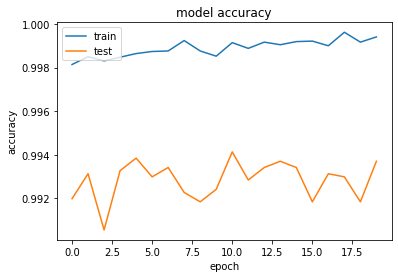

In [12]:
# summarize history for accuracy
plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
model.save('model.h5')

Test how model trained on 0-6 classifies 7-9.

In [14]:
target_train_mask79 = np.isin(y_train,[7,8,9])
target_test_mask79 = np.isin(y_test,[7,8,9])


x_train79, y_train79 = x_train[target_train_mask79], y_train[target_train_mask79]
x_test79, y_test79 = x_test[target_test_mask79], y_test[target_test_mask79]



x_train79 = x_train79.reshape(x_train79.shape[0], 28, 28, 1)
x_test79 = x_test79.reshape(x_test79.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train79 = x_train79.astype('float32')
x_test79 = x_test79.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train79 /= 255
x_test79 /= 255

y_train79 -= 7
y_test79 -= 7

In [16]:
newModel = Model(inputs=model.inputs, outputs=model.layers[-2].output)


flat1 = Flatten()(model.layers[-1].output)
#class1 = Dense(1024, activation='relu')(flat1)
output = Dense(3, activation='softmax')(flat1)
# define new model
newModel = Model(inputs=model.inputs, outputs=output)
# summarize
newModel.summary()
newModel.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

newModel.fit(x=x_train79,y=y_train79, epochs=20)
history_newmodel = newModel.fit(x_train79, y_train79, epochs=20, batch_size=10,validation_data=(x_test79, y_test79), shuffle=True)


Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 28)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4732)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               605824    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                

In [17]:
newModel.save('newModel.h5')

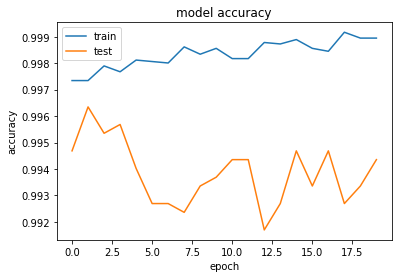

In [18]:
# summarize history for accuracy
plt.plot(history_newmodel.history['accuracy'])
plt.plot(history_newmodel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Training a freshly initialized model on the target domain data set

In [20]:
model_3 = Sequential()
    # add Convolutional layers
model_3.add(Conv2D(28,kernel_size=(3,3), activation='relu',input_shape=input_shape))
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2,2)))    
model_3.add(Flatten())
    # Densely connected layers
model_3.add(Dense(128, activation='relu'))
    # output layer
model_3.add(Dense(3, activation='softmax'))
    # compile with adam optimizer & categorical_crossentropy loss function
model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])











# model_3 = Sequential()
# model_3.add(Conv2D(28, kernel_size=(3,3), activation='relu', input_shape=input_shape))
# model_3.add(MaxPooling2D(pool_size=(2, 2)))
# model_3.add(Flatten()) 
# model_3.add(Dense(128, activation='relu'))
# model_3.add(Dropout(0.2))
# model_3.add(Dense(3,activation='softmax'))

# model_3.compile(optimizer='adam', 
#                   loss='sparse_categorical_crossentropy', 
#                   metrics=['accuracy'])

#print(model.summary())


In [21]:
#model_3.fit(x=x_train79,y=y_train79 , epochs=20)
model_3.fit(x=x_train79,y=y_train79, epochs=20)
history_model_3 = model_3.fit(x_train79, y_train79,epochs=20, batch_size=10, validation_data=(x_test79, y_test79), shuffle=True)

Epoch 1/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0952 - accuracy: 0.9680
Epoch 2/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0195 - accuracy: 0.9939
Epoch 3/20
565/565 [==============================] - 1s 3ms/step - loss: 0.0160 - accuracy: 0.9952
Epoch 4/20
565/565 [==============================] - 1s 3ms/step - loss: 0.0101 - accuracy: 0.9962
Epoch 5/20
565/565 [==============================] - 1s 3ms/step - loss: 0.0088 - accuracy: 0.9972
Epoch 6/20
565/565 [==============================] - 1s 3ms/step - loss: 0.0055 - accuracy: 0.9980
Epoch 7/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0042 - accuracy: 0.9986
Epoch 8/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0053 - accuracy: 0.9985
Epoch 9/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0038 - accuracy: 0.9989
Epoch 10/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0046 - accuracy: 0.9985

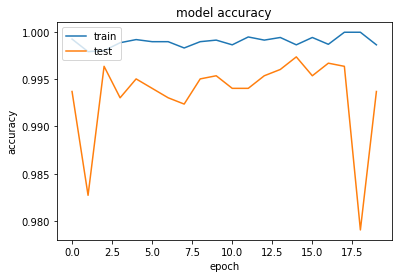

In [22]:
# summarize history for accuracy
plt.plot(history_model_3.history['accuracy'])
plt.plot(history_model_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
model_3.save('model_3.h5')

**Comparison of new model and transfer model**

1. Achieved accuracy: Model prepared from scratch give more accuracy on test data as well as compared to the transferred model.

2. Steps until convergence: Model prepared from scratch converged faster on training set as compared to the transferred model.

3. Generalization: Transferred model didn't generalise well as compared to the model prepared from scratch.

**TASK 3.2 Different Distribution**
1. Train a model on MNIST and use it as initialisation model for FMNIST.
2. Train a model from scratch on FMNIST.
3. Train a model on FMNIST and use it as initialisation model for MNIST

 Train a model on MNIST and use it as initialisation model for FMNIST.




In [6]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255

In [7]:
model_4 = Sequential()
    # add Convolutional layers
model_4.add(Conv2D(28,kernel_size=(3,3), activation='relu',input_shape=input_shape))
model_4.add(MaxPooling2D(pool_size=(2,2)))
model_4.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model_4.add(MaxPooling2D(pool_size=(2,2)))
model_4.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model_4.add(MaxPooling2D(pool_size=(2,2)))    
model_4.add(Flatten())
    # Densely connected layers
model_4.add(Dense(128, activation='relu'))
    # output layer
model_4.add(Dense(10, activation='softmax'))
    # compile with adam optimizer & categorical_crossentropy loss function
model_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
model_4.fit(x=x_train,y=y_train , epochs=20)
history_model_4 = model_4.fit(x_train, y_train,epochs=20, batch_size=10, validation_data=(x_test, y_test), shuffle=True)

Epoch 1/20
1875/1875 [==============================] - 5s 3ms/step - loss: 2.3015 - accuracy: 0.1116
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 2.3014 - accuracy: 0.1124
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 2.3014 - accuracy: 0.1124
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 2.3014 - accuracy: 0.1124
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 2.3014 - accuracy: 0.1124
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 2.3013 - accuracy: 0.1124
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 2.3014 - accuracy: 0.1124
Epoch 8/20
1875/1875 [==============================] - 5s 3ms/step - loss: 2.3014 - accuracy: 0.1124
Epoch 9/20
1875/1875 [==============================] - 5s 3ms/step - loss: 2.3013 - accuracy: 0.1124
Epoch 10/20
1875/1875 [==============================] - 5s 3ms/step - loss: 2.301

Use model 4 (MNIST) as initial model for FMNIST

In [9]:
# Load the fashion-mnist pre-shuffled train data and test data
(fx_train, fy_train), (fx_test, fy_test) = tf.keras.datasets.fashion_mnist.load_data()
print("fx_train shape:", fx_train.shape, "fy_train shape:", fy_train.shape)

4423680/4422102 [==============================] - 0s 0us/step
fx_train shape: (60000, 28, 28) fy_train shape: (60000,)


In [10]:
fx_train = fx_train.astype('float32') / 255
fx_test = fx_test.astype('float32') / 255

In [11]:
w, h = 28, 28
fx_train = fx_train.reshape(fx_train.shape[0], w, h, 1)
fx_test = fx_test.reshape(fx_test.shape[0], w, h, 1)

# One-hot encode the labels
fy_train = tf.keras.utils.to_categorical(fy_train, 10)
fy_test = tf.keras.utils.to_categorical(fy_test, 10)

In [12]:
fnewModel = Model(inputs=model_4.inputs, outputs=model_4.layers[-2].output)


flat1 = Flatten()(model_4.layers[-1].output)
#class1 = Dense(1024, activation='relu')(flat1)
output = Dense(10, activation='softmax')(flat1)
# define new model
fnewModel = Model(inputs=model_4.inputs, outputs=output)
# summarize
fnewModel.summary()
fnewModel.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

fnewModel.fit(x=fx_train,y=fy_train, epochs=20)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3_input (InputLayer)  [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 28)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        16192     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 6, 64)          36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 64)         

In [30]:

history_fnewModel = fnewModel.fit(fx_train, fy_train,epochs=20, batch_size=10, validation_data=(fx_test, fy_test), shuffle=True)

Epoch 1/20
6000/6000 [==============================] - 20s 3ms/step - loss: 0.0992 - accuracy: 0.9691 - val_loss: 0.4314 - val_accuracy: 0.9021
Epoch 2/20
6000/6000 [==============================] - 20s 3ms/step - loss: 0.1013 - accuracy: 0.9691 - val_loss: 0.4007 - val_accuracy: 0.9037
Epoch 3/20
6000/6000 [==============================] - 20s 3ms/step - loss: 0.1040 - accuracy: 0.9686 - val_loss: 0.4160 - val_accuracy: 0.9001
Epoch 4/20
6000/6000 [==============================] - 20s 3ms/step - loss: 0.1055 - accuracy: 0.9682 - val_loss: 0.4161 - val_accuracy: 0.9010
Epoch 5/20
6000/6000 [==============================] - 20s 3ms/step - loss: 0.0987 - accuracy: 0.9700 - val_loss: 0.4113 - val_accuracy: 0.9087
Epoch 6/20
6000/6000 [==============================] - 20s 3ms/step - loss: 0.0968 - accuracy: 0.9708 - val_loss: 0.4226 - val_accuracy: 0.9040
Epoch 7/20
6000/6000 [==============================] - 19s 3ms/step - loss: 0.0955 - accuracy: 0.9721 - val_loss: 0.4364 - val_ac

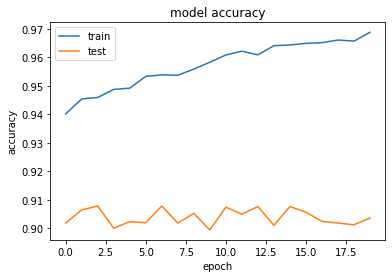

In [14]:
# summarize history for accuracy
plt.plot(history_fnewModel.history['accuracy'])
plt.plot(history_fnewModel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

USE FMNIST AS SOURCE AND MNIST AS TARGET

In [15]:
# Load the fashion-mnist pre-shuffled train data and test data
(fx_train, fy_train), (fx_test, fy_test) = tf.keras.datasets.fashion_mnist.load_data()
print("fx_train shape:", fx_train.shape, "fy_train shape:", fy_train.shape)

fx_train shape: (60000, 28, 28) fy_train shape: (60000,)


In [16]:
fx_train = fx_train.astype('float32') / 255
fx_test = fx_test.astype('float32') / 255

In [17]:
w, h = 28, 28
fx_train = fx_train.reshape(fx_train.shape[0], w, h, 1)
fx_test = fx_test.reshape(fx_test.shape[0], w, h, 1)

# One-hot encode the labels
fy_train = tf.keras.utils.to_categorical(fy_train, 10)
fy_test = tf.keras.utils.to_categorical(fy_test, 10)

In [18]:
fmnist_model_scratch = tf.keras.Sequential()
# Must define the input shape in the first layer of the neural network
fmnist_model_scratch.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
fmnist_model_scratch.add(tf.keras.layers.MaxPooling2D(pool_size=2))
fmnist_model_scratch.add(tf.keras.layers.Dropout(0.3))
fmnist_model_scratch.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
fmnist_model_scratch.add(tf.keras.layers.MaxPooling2D(pool_size=2))
fmnist_model_scratch.add(tf.keras.layers.Dropout(0.3))
fmnist_model_scratch.add(tf.keras.layers.Flatten())
fmnist_model_scratch.add(tf.keras.layers.Dense(256, activation='relu'))
fmnist_model_scratch.add(tf.keras.layers.Dropout(0.5))
fmnist_model_scratch.add(tf.keras.layers.Dense(10, activation='softmax'))
# Take a look at the model summary
#fmnist_model_scratch.summary()

In [19]:
fmnist_model_scratch.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [20]:
fmnist_model_scratch.fit(x=fx_train,
         y=fy_train,
         epochs=20)

Epoch 1/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5455 - accuracy: 0.7993
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3974 - accuracy: 0.8551
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3574 - accuracy: 0.8692
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3344 - accuracy: 0.8763
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3162 - accuracy: 0.8850
Epoch 6/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3003 - accuracy: 0.8900
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2883 - accuracy: 0.8929
Epoch 8/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2805 - accuracy: 0.8969
Epoch 9/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2698 - accuracy: 0.8995
Epoch 10/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.264

Epoch 1/20
6000/6000 [==============================] - 19s 3ms/step - loss: 0.2541 - accuracy: 0.9082 - val_loss: 0.2435 - val_accuracy: 0.9153
Epoch 2/20
6000/6000 [==============================] - 20s 3ms/step - loss: 0.2526 - accuracy: 0.9081 - val_loss: 0.2639 - val_accuracy: 0.9091
Epoch 3/20
6000/6000 [==============================] - 19s 3ms/step - loss: 0.2568 - accuracy: 0.9068 - val_loss: 0.2615 - val_accuracy: 0.9112
Epoch 4/20
6000/6000 [==============================] - 19s 3ms/step - loss: 0.2526 - accuracy: 0.9094 - val_loss: 0.2788 - val_accuracy: 0.9065
Epoch 5/20
6000/6000 [==============================] - 19s 3ms/step - loss: 0.2525 - accuracy: 0.9075 - val_loss: 0.2575 - val_accuracy: 0.9096
Epoch 6/20
6000/6000 [==============================] - 19s 3ms/step - loss: 0.2526 - accuracy: 0.9083 - val_loss: 0.2605 - val_accuracy: 0.9118
Epoch 7/20
6000/6000 [==============================] - 20s 3ms/step - loss: 0.2506 - accuracy: 0.9106 - val_loss: 0.2539 - val_ac

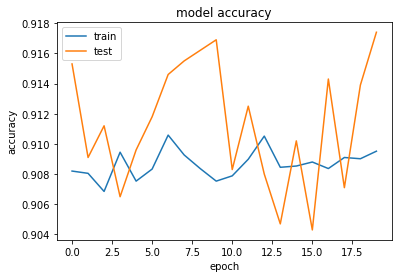

In [22]:

history_fmnist_model_scratch = fmnist_model_scratch.fit(fx_train, fy_train,epochs=20, batch_size=10, validation_data=(fx_test, fy_test), shuffle=True)
# summarize history for accuracy
plt.plot(history_fmnist_model_scratch.history['accuracy'])
plt.plot(history_fmnist_model_scratch.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# plt.plot(history_fnewModel.history['accuracy'])
# plt.plot(history_fnewModel.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()


Use fmnist_model as source for mnist

In [31]:
fnewModelMNIST = Model(inputs=fmnist_model_scratch.inputs, outputs=fmnist_model_scratch.layers[-2].output)


flat1 = Flatten()(fmnist_model_scratch.layers[-1].output)
output = Dense(1024, activation='relu')(flat1)
output = Dense(10, activation='softmax')(class1)
# define new model
fnewModelMNIST = Model(inputs=fmnist_model_scratch.inputs, outputs=output)

fnewModelMNIST.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

fnewModelMNIST.fit(x=x_train,y=y_train, epochs=20)

Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.9486 - accuracy: 0.3373
Epoch 2/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.9250 - accuracy: 0.3324
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.8651 - accuracy: 0.3611
Epoch 4/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.8130 - accuracy: 0.3789
Epoch 5/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.7842 - accuracy: 0.3956
Epoch 6/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.7392 - accuracy: 0.4114
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.7743 - accuracy: 0.3980
Epoch 8/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.8000 - accuracy: 0.3932
Epoch 9/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.7396 - accuracy: 0.4090
Epoch 10/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.710

In [32]:
history_fnewModelMNIST = fnewModelMNIST.fit(x_train, y_train,epochs=20, batch_size=10, validation_data=(x_test, y_test), shuffle=True)

Epoch 1/20
6000/6000 [==============================] - 18s 3ms/step - loss: 1.7513 - accuracy: 0.3995 - val_loss: 1.5942 - val_accuracy: 0.4578
Epoch 2/20
6000/6000 [==============================] - 18s 3ms/step - loss: 1.7323 - accuracy: 0.4022 - val_loss: 1.3741 - val_accuracy: 0.4999
Epoch 3/20
6000/6000 [==============================] - 18s 3ms/step - loss: 1.8068 - accuracy: 0.3654 - val_loss: 1.8912 - val_accuracy: 0.3027
Epoch 4/20
6000/6000 [==============================] - 18s 3ms/step - loss: 2.0700 - accuracy: 0.2465 - val_loss: 2.0068 - val_accuracy: 0.2478
Epoch 5/20
6000/6000 [==============================] - 19s 3ms/step - loss: 2.1042 - accuracy: 0.2291 - val_loss: 1.9401 - val_accuracy: 0.2628
Epoch 6/20
6000/6000 [==============================] - 18s 3ms/step - loss: 2.0667 - accuracy: 0.2536 - val_loss: 1.8663 - val_accuracy: 0.2744
Epoch 7/20
6000/6000 [==============================] - 18s 3ms/step - loss: 1.8830 - accuracy: 0.3323 - val_loss: 1.6117 - val_ac

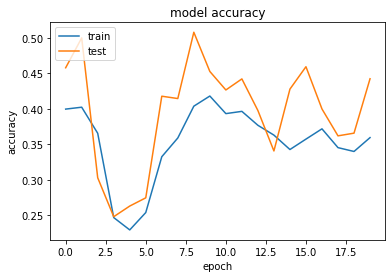

In [34]:
# summarize history for accuracy
plt.plot(history_fnewModelMNIST.history['accuracy'])
plt.plot(history_fnewModelMNIST.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Now we will work with MNIST as source domain and FMNIST as target domain. (This is convenient, as they already have the same input shape.)
Similar to 3.1, first train a model on the MNIST and use the pre-trained model as initialization for a model trained on FMNIST.
Compare this transfer learned model with a model trained on FMNIST from scratch using the measures from 3.1.

Repeat the experiment with FMNIST as source and MNIST as target!
Does transfer learning work better or worse this time?
1. MNIST as source and FMNIST as target: The transferred model is not generalizing well as compared to the model prepared from scratch.
2. FMNIST as source and MNIST as target: Here the accuracy of the model is hampered and it is around 50 percent,


**Other Experiments**
1. Freezing all pre-trained layers. (Trainable = False)
2. Freezing only some bottom layers. (Trainable = False)
3. Replace multiple top layers.
4. Replace classification layer by more layers.

I am experimenting these in similar datasets , MNIST 0-6 as source and MNIST 7-9 as target.

1. Freezing all pre-trained layers. (Trainable = false)

In [35]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [36]:
num_digits_to_classify = 7
source_train_mask06 = np.isin(y_train,[0,1,2,3,4,5,6])
source_test_mask06 = np.isin(y_test,[0,1,2,3,4,5,6])
x_train06, y_train06 = x_train[source_train_mask06], y_train[source_train_mask06]
x_test06, y_test06 = x_test[source_test_mask06], y_test[source_test_mask06]

In [37]:
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train06 = x_train06.reshape(x_train06.shape[0], 28, 28, 1)
x_test06 = x_test06.reshape(x_test06.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train06 = x_train06.astype('float32')
x_test06 = x_test06.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train06 /= 255
x_test06 /= 255

In [38]:
def create_model():
    model = Sequential()
    model.add(Conv2D(28, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_digits_to_classify,activation='softmax'))

    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

model = create_model()
model.summary()
model.fit(x=x_train06,y=y_train06, epochs=20)
history_model = model.fit(x_train06, y_train06, epochs=20, batch_size=10, validation_data=(x_test06, y_test06), shuffle=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 28)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 4732)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               605824    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 7)                 903       
Total params: 607,007
Trainable params: 607,007
Non-trainable params: 0
________________________________________________

In [39]:
target_train_mask79 = np.isin(y_train,[7,8,9])
target_test_mask79 = np.isin(y_test,[7,8,9])


x_train79, y_train79 = x_train[target_train_mask79], y_train[target_train_mask79]
x_test79, y_test79 = x_test[target_test_mask79], y_test[target_test_mask79]



x_train79 = x_train79.reshape(x_train79.shape[0], 28, 28, 1)
x_test79 = x_test79.reshape(x_test79.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train79 = x_train79.astype('float32')
x_test79 = x_test79.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train79 /= 255
x_test79 /= 255

y_train79 -= 7
y_test79 -= 7

In [41]:
for layer in model.layers:
    layer.trainable = False

In [42]:
newModel = Model(inputs=model.inputs, outputs=model.layers[-2].output)


flat1 = Flatten()(model.layers[-1].output)
#class1 = Dense(1024, activation='relu')(flat1)
output = Dense(3, activation='softmax')(flat1)
# define new model
newModel = Model(inputs=model.inputs, outputs=output)
# summarize
newModel.summary()
newModel.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

newModel.fit(x=x_train79,y=y_train79, epochs=20)
history_newmodel = newModel.fit(x_train79, y_train79, epochs=20, batch_size=10,validation_data=(x_test79, y_test79), shuffle=True)

Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8_input (InputLayer)  [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 28)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 4732)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               605824    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 7)               

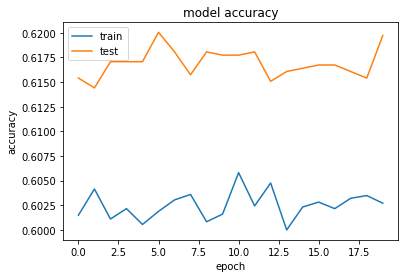

In [43]:
# summarize history for accuracy
plt.plot(history_newmodel.history['accuracy'])
plt.plot(history_newmodel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

2. Freezing some layers

In [51]:
def create_model():
    model = Sequential()
    
    model.add(Conv2D(28, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_digits_to_classify,activation='softmax'))

    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

model = create_model()
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 28)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 13, 13, 64)        16192     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 6, 6, 64)          36928     
_________________________________________________________________
flatten_14 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)              

In [52]:
model.fit(x=x_train06,y=y_train06, epochs=20)
history_model = model.fit(x_train06, y_train06, epochs=20, batch_size=10, validation_data=(x_test06, y_test06), shuffle=True)

Epoch 1/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0905 - accuracy: 0.9714
Epoch 2/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0264 - accuracy: 0.9924
Epoch 3/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0189 - accuracy: 0.9941
Epoch 4/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0153 - accuracy: 0.9953
Epoch 5/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0118 - accuracy: 0.9965
Epoch 6/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0093 - accuracy: 0.9969
Epoch 7/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0082 - accuracy: 0.9973
Epoch 8/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0070 - accuracy: 0.9978
Epoch 9/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0066 - accuracy: 0.9981
Epoch 10/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.003

In [53]:
target_train_mask79 = np.isin(y_train,[7,8,9])
target_test_mask79 = np.isin(y_test,[7,8,9])


x_train79, y_train79 = x_train[target_train_mask79], y_train[target_train_mask79]
x_test79, y_test79 = x_test[target_test_mask79], y_test[target_test_mask79]



x_train79 = x_train79.reshape(x_train79.shape[0], 28, 28, 1)
x_test79 = x_test79.reshape(x_test79.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train79 = x_train79.astype('float32')
x_test79 = x_test79.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train79 /= 255
x_test79 /= 255

y_train79 -= 7
y_test79 -= 7

In [54]:
for layer in model.layers:
  print(layer.name) 

conv2d_13
max_pooling2d_12
conv2d_14
max_pooling2d_13
conv2d_15
flatten_14
dense_21
dropout_5
dense_22


In [55]:
for layer in model.layers:
  if ('max_pooling2d' in layer.name):
    layer.trainable = False

In [57]:
newModel = Model(inputs=model.inputs, outputs=model.layers[-2].output)


flat1 = Flatten()(model.layers[-1].output)
#class1 = Dense(1024, activation='relu')(flat1)
output = Dense(3, activation='softmax')(flat1)
# define new model
newModel = Model(inputs=model.inputs, outputs=output)

newModel.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

newModel.fit(x=x_train79,y=y_train79, epochs=20)
history_newmodel = newModel.fit(x_train79, y_train79, epochs=20, batch_size=10,validation_data=(x_test79, y_test79), shuffle=True)

Epoch 1/20
565/565 [==============================] - 2s 3ms/step - loss: 0.6110 - accuracy: 0.9942
Epoch 2/20
565/565 [==============================] - 2s 3ms/step - loss: 0.3136 - accuracy: 0.9949
Epoch 3/20
565/565 [==============================] - 2s 3ms/step - loss: 0.1839 - accuracy: 0.9940
Epoch 4/20
565/565 [==============================] - 2s 3ms/step - loss: 0.1136 - accuracy: 0.9965
Epoch 5/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0804 - accuracy: 0.9963
Epoch 6/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0727 - accuracy: 0.9931
Epoch 7/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0549 - accuracy: 0.9949
Epoch 8/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0478 - accuracy: 0.9949
Epoch 9/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0544 - accuracy: 0.9922
Epoch 10/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0350 - accuracy: 0.9959

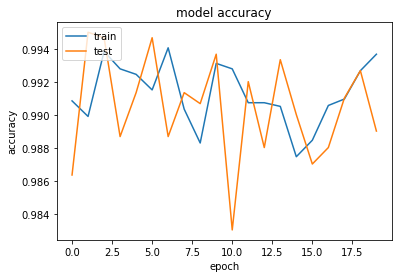

In [59]:
# summarize history for accuracy
plt.plot(history_newmodel.history['accuracy'])
plt.plot(history_newmodel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

3. replacing (or reinitializing) multiple top layers

In [73]:
def create_model():
    model = Sequential()
    
    model.add(Conv2D(28, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_digits_to_classify,activation='softmax'))

    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

model = create_model()
#model.summary()

In [74]:
model.fit(x=x_train06,y=y_train06, epochs=20)
history_model = model.fit(x_train06, y_train06, epochs=20, batch_size=10, validation_data=(x_test06, y_test06), shuffle=True)

Epoch 1/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0893 - accuracy: 0.9726
Epoch 2/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0270 - accuracy: 0.9918
Epoch 3/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0198 - accuracy: 0.9937
Epoch 4/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0146 - accuracy: 0.9958
Epoch 5/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0125 - accuracy: 0.9959
Epoch 6/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0103 - accuracy: 0.9966
Epoch 7/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0093 - accuracy: 0.9969
Epoch 8/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0065 - accuracy: 0.9977
Epoch 9/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0065 - accuracy: 0.9980
Epoch 10/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.005

In [75]:
target_train_mask79 = np.isin(y_train,[7,8,9])
target_test_mask79 = np.isin(y_test,[7,8,9])


x_train79, y_train79 = x_train[target_train_mask79], y_train[target_train_mask79]
x_test79, y_test79 = x_test[target_test_mask79], y_test[target_test_mask79]



x_train79 = x_train79.reshape(x_train79.shape[0], 28, 28, 1)
x_test79 = x_test79.reshape(x_test79.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train79 = x_train79.astype('float32')
x_test79 = x_test79.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train79 /= 255
x_test79 /= 255

y_train79 -= 7
y_test79 -= 7

In [76]:
# Replace multiple layers
newModel = Model(inputs=model.inputs, outputs=model.layers[-4].output)


flat1 = Flatten()(model.layers[-1].output)
#class1 = Dense(1024, activation='relu')(flat1)
output = Dense(3, activation='softmax')(flat1)
# define new model
newModel = Model(inputs=model.inputs, outputs=output)

newModel.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

newModel.fit(x=x_train79,y=y_train79, epochs=20)
history_newmodel = newModel.fit(x_train79, y_train79, epochs=20, batch_size=10,validation_data=(x_test79, y_test79), shuffle=True)

Epoch 1/20
565/565 [==============================] - 2s 3ms/step - loss: 0.6581 - accuracy: 0.9226
Epoch 2/20
565/565 [==============================] - 2s 3ms/step - loss: 0.2899 - accuracy: 0.9828
Epoch 3/20
565/565 [==============================] - 2s 3ms/step - loss: 0.1751 - accuracy: 0.9856
Epoch 4/20
565/565 [==============================] - 2s 3ms/step - loss: 0.1242 - accuracy: 0.9872
Epoch 5/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0928 - accuracy: 0.9895
Epoch 6/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0747 - accuracy: 0.9910
Epoch 7/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0653 - accuracy: 0.9909
Epoch 8/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0558 - accuracy: 0.9921
Epoch 9/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0587 - accuracy: 0.9907
Epoch 10/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0477 - accuracy: 0.9930

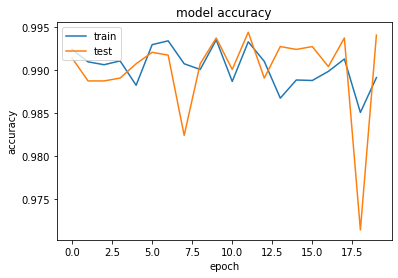

In [77]:
# summarize history for accuracy
plt.plot(history_newmodel.history['accuracy'])
plt.plot(history_newmodel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

4. Replacing the source classification layer by multiple new ones for the target domain.

In [65]:
def create_model():
    model = Sequential()
    
    model.add(Conv2D(28, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_digits_to_classify,activation='softmax'))

    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

model = create_model()
#model.summary()

In [66]:
model.fit(x=x_train06,y=y_train06, epochs=20)
history_model = model.fit(x_train06, y_train06, epochs=20, batch_size=10, validation_data=(x_test06, y_test06), shuffle=True)

Epoch 1/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0923 - accuracy: 0.9708
Epoch 2/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0270 - accuracy: 0.9913
Epoch 3/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0184 - accuracy: 0.9942
Epoch 4/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0146 - accuracy: 0.9953
Epoch 5/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0120 - accuracy: 0.9964
Epoch 6/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0099 - accuracy: 0.9967
Epoch 7/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0073 - accuracy: 0.9974
Epoch 8/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0083 - accuracy: 0.9976
Epoch 9/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.0060 - accuracy: 0.9981
Epoch 10/20
1311/1311 [==============================] - 4s 3ms/step - loss: 0.005

In [67]:
target_train_mask79 = np.isin(y_train,[7,8,9])
target_test_mask79 = np.isin(y_test,[7,8,9])


x_train79, y_train79 = x_train[target_train_mask79], y_train[target_train_mask79]
x_test79, y_test79 = x_test[target_test_mask79], y_test[target_test_mask79]



x_train79 = x_train79.reshape(x_train79.shape[0], 28, 28, 1)
x_test79 = x_test79.reshape(x_test79.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train79 = x_train79.astype('float32')
x_test79 = x_test79.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train79 /= 255
x_test79 /= 255

y_train79 -= 7
y_test79 -= 7

In [79]:
# define new model
newModel = Model(inputs=model.inputs, outputs=output)

flat1 = Flatten()(model.layers[-1].output)
dense1 = Dense(3, activation='relu')(flat1)
dense2 = Dense(3, activation='relu')(dense1)
#class1 = Dense(1024, activation='relu')(flat1)
output = Dense(3, activation='softmax')(dense2)
newModel.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

newModel.fit(x=x_train79,y=y_train79, epochs=20)
history_newmodel = newModel.fit(x_train79, y_train79, epochs=20, batch_size=10,validation_data=(x_test79, y_test79), shuffle=True)

Epoch 1/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0462 - accuracy: 0.9929
Epoch 2/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0453 - accuracy: 0.9928
Epoch 3/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0532 - accuracy: 0.9911
Epoch 4/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0437 - accuracy: 0.9930
Epoch 5/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0530 - accuracy: 0.9909
Epoch 6/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0389 - accuracy: 0.9936
Epoch 7/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0419 - accuracy: 0.9932
Epoch 8/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0444 - accuracy: 0.9926
Epoch 9/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0722 - accuracy: 0.9876
Epoch 10/20
565/565 [==============================] - 2s 3ms/step - loss: 0.0498 - accuracy: 0.9909

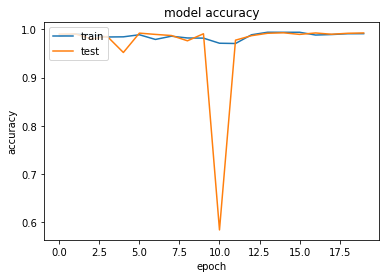

In [80]:
# summarize history for accuracy
plt.plot(history_newmodel.history['accuracy'])
plt.plot(history_newmodel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Comparison of various techniques**
1. Freezing all layers: The model did not generalize and accuracy is also dropped significantly.

2. Freezing some layers: Accuracy improved compared to the model where all layers are freezed. It also generalized well.

3. Replacing Multiple Layers: Generalizes well and accuracy is comparable to the model in which some layers are freezed.

4. Replacing source classification layer and adding multiple layers: This model performed very well as compared to all other models. The model is highly generalised and accuracy is also good.